<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Issues" data-toc-modified-id="Issues-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Issues</a></span></li><li><span><a href="#solution-1" data-toc-modified-id="solution-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>solution 1</a></span></li></ul></div>

## Issues
There are a lot of artifacts in the signals, such as 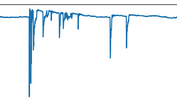. And that's really difficult to do labeling with those artifacts.

In [100]:
import numpy as np
from hdf5storage import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from scipy import signal

In [101]:
def signal_filter(data, sf=305., btype='lowpass', low=0.5, high=30):
    """
    Filter the signal data, use butter filter in scipy
    
    Parameters
    ----------
    data : 1D-array
        Signal data need to be filtered.
    sf : float
        Sampling frequency of signal data. Default is 305.
    btype : {'lowpass', 'highpass', 'bandpass'}, optional
        The type of filter. Default is 'lowpass'.
    low : float
        Higher than this frequency can pass, used in 'highpass' and 'bandpass'
        filter. Default is 0.5.
    higer : float
        Lower than this frequency can pass, used in 'lowpass' and 'bandpass' 
        filyer. Default is 30.
    
    Returns
    ----------
    filtered_data : 1D-array
        Filtered data of signal data using butter filter
    
    """
    if btype == 'lowpass':
        fnorm = high / (.5 * sf)
    elif btype == 'highpass':
        fnorm = low / (.5 * sf)
    elif btype == 'bandpass':
        fnorm = np.divide([low, high], .5 * sf)
    else:
        raise ValueError("'%s' is an invalid type for filter, "
                         "you can only choose 'lowpass', 'highpass' or 'bandpass'" 
                         % btype)
    
    # Use irrfilter of scipy.signal to construct a filter
    b, a = signal.iirfilter(N=3, Wn=fnorm, btype=btype, analog=False, 
                            output='ba', ftype='butter', fs=None) 
    
    filtered_data = signal.filtfilt(b=b, a=a, x=data)
    
    return filtered_data

In [102]:
data = list(loadmat(r'E:/workplace/EEGProcessing/00_DATA/20240117_0700_WXQ_3mice_24h/mouse1/mouse1.mat').values())[-1]
data = np.array(data)

In [103]:
data_dict = {
    'eeg1': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
    'eeg2': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
    'eeg3': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
    'eeg4': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
    'emg': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
    'ref': signal_filter(data[0], btype='bandpass', low=0.5, high=45),
}

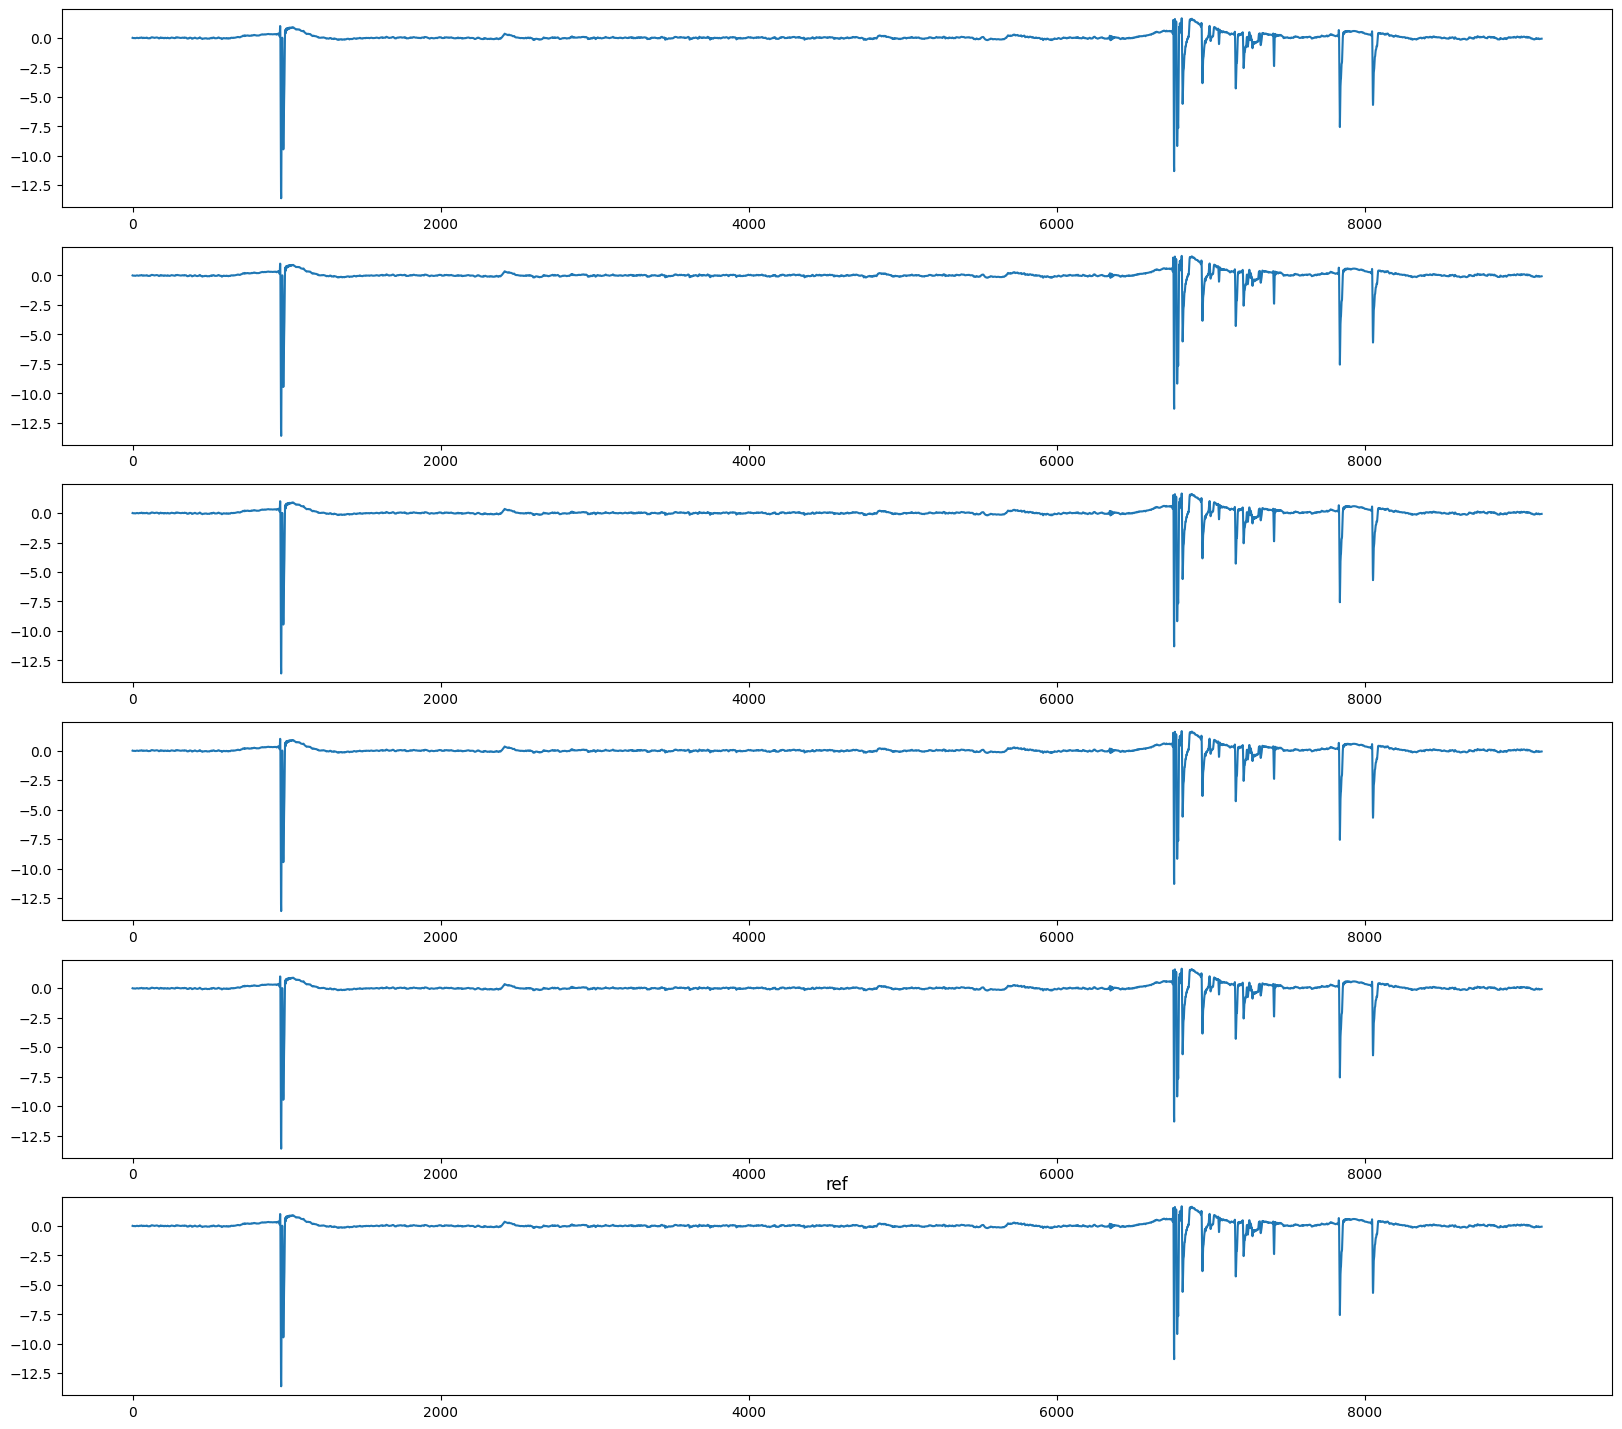

In [122]:
fig, ax = plt.subplots(6, 1, figsize=(20, 18))
i = 0
for key, value in data_dict.items():
    ax[i].plot(value[:30*305])
    plt.title(key)
    i += 1

## solution 1
Calculate the 75% of the signal, if the value is greater, then it is an artifact

percentile: artifact threshold, relative in each signal, larger than percentile

quantile_value: the real quantile value in the signal computed by percentile

real_max_value: real max value of signal

$$adjust\_max\_value = \frac{quantile\_value \times 0.5}{(percentile - 0.5)}$$
$$adjust\_art\_value = \frac{(real\_art\_value - quantile\_value)\times(adjust\_max\_value - quantile\_value)}{real\_max\_value - quantile\_value}  + quantile\_value$$

(-0.1, 0.1)

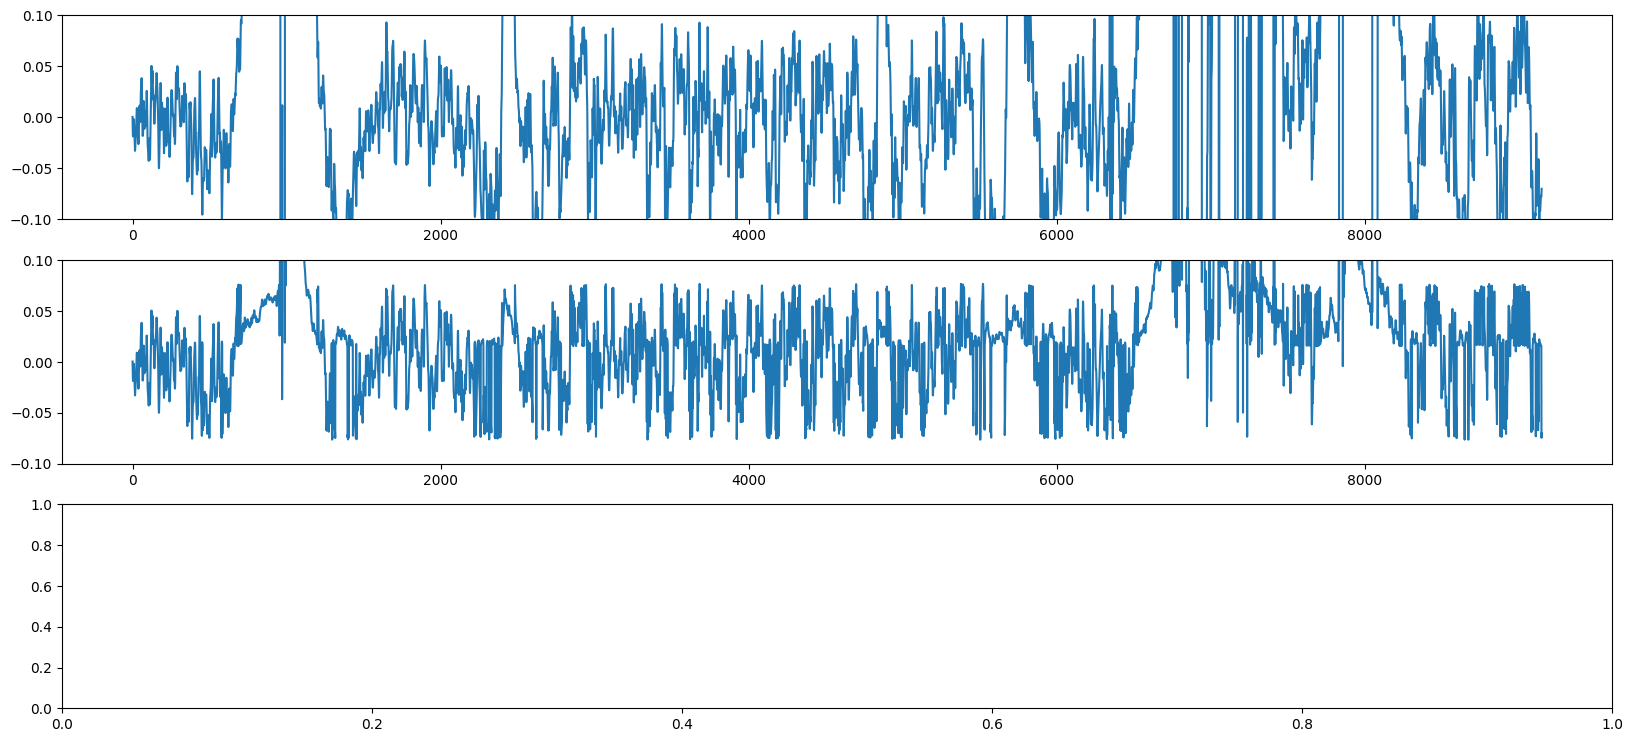

In [151]:
def scalar(percentile, quantile_value, max_value, real_value):
    adj_max = quantile_value * 0.5 / (percentile - 0.5)
    adj_value = (real_value - quantile_value) * (adj_max - quantile_value) / (max_value - quantile_value)
    
    return adj_value
    

show_sec = 30
percentile = 95

quantile_eeg1 = np.percentile(data_dict['eeg1'], percentile)
max_eeg1 = data_dict['eeg1'].max()

# median = np.percentile()
rm_art_eeg1 = []

for each in data_dict['eeg1'][:show_sec*305]:
    if np.abs(each) > quantile_eeg1 and each > 0:
        rm_art_eeg1.append(each*0.2)
    elif np.abs(each) > quantile_eeg1 and each < 0:
        rm_art_eeg1.append(-each*0.2)
    else:
        rm_art_eeg1.append(each)
rm_art_eeg1 = np.array(rm_art_eeg1)

# rm_art_eeg1_filter = signal_filter(rm_art_eeg1, btype='highpass', low=0.5)

fig, ax = plt.subplots(3, 1, figsize=(20, 9))
ax[0].plot(data_dict['eeg1'][:30*305])
ax[0].set_ylim([-0.1, 0.1])
ax[1].plot(rm_art_eeg1)
ax[1].set_ylim([-0.1, 0.1])
# ax[2].plot(rm_art_eeg1_filter)
# ax[2].set_ylim([-0.1, 0.1])

In [116]:
np.abs(data_dict['eeg1'][0])

0.00026343729495750595

In [117]:
data_dict['eeg1'].max()

5.68583254882669

In [130]:
rm_art_eeg1_filter = signal_filter(rm_art_eeg1, btype='highpass', low=2)

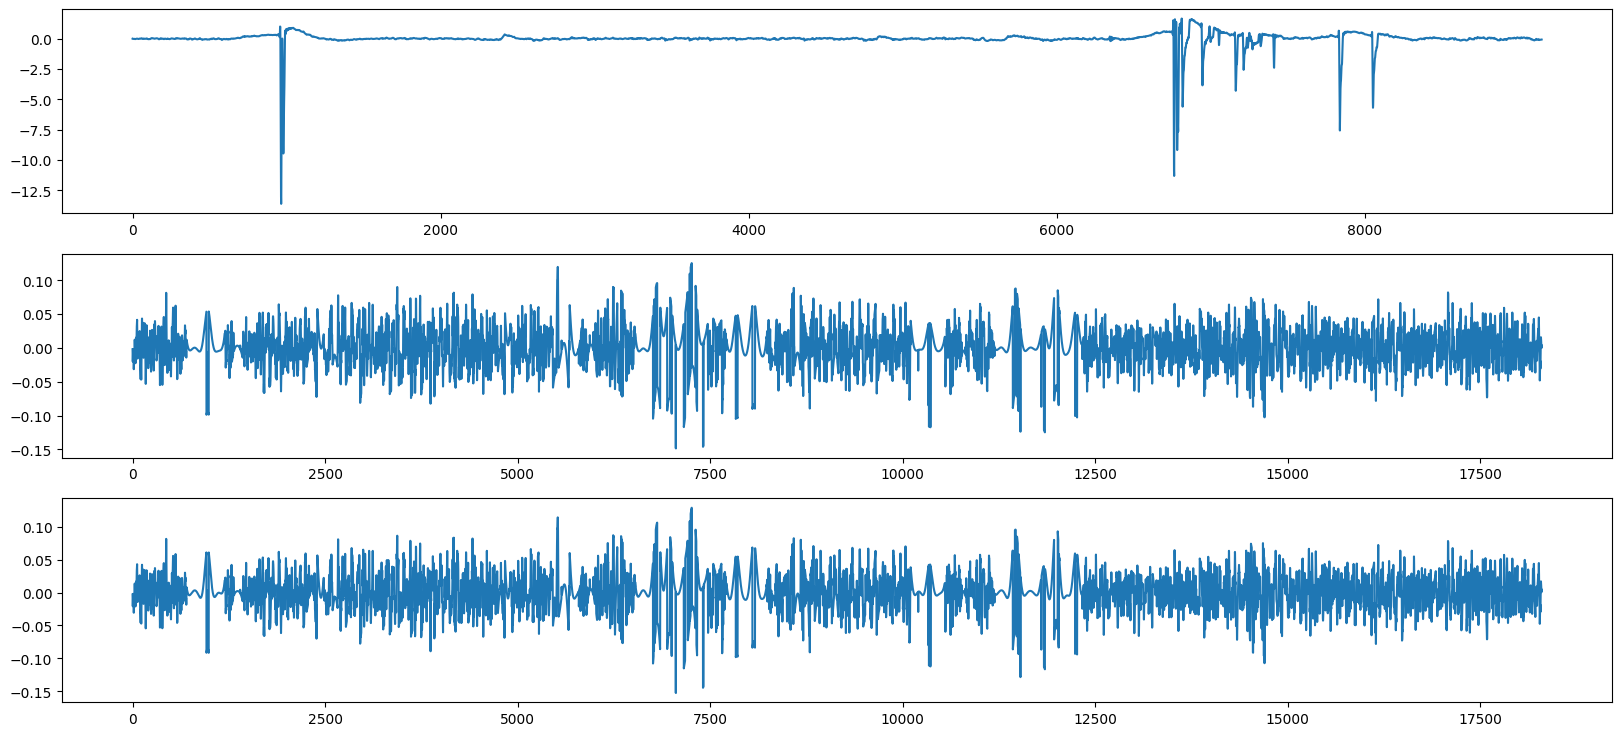

In [133]:
fig, ax = plt.subplots(3, 1, figsize=(20, 9))
ax[0].plot(data_dict['eeg1'][:30*305])
ax[1].plot(rm_art_eeg1)
ax[2].plot(rm_art_eeg1_filter)